In [4]:
import pandas as pd
import os

print(os.listdir("./datasets/titanic"))
train = pd.read_csv("./datasets/titanic/train.csv")
test = pd.read_csv("./datasets/titanic/test.csv")

['gender_submission.csv', 'test.csv', 'train.csv']


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [32]:
import numpy as np

class CombinedAttributesAdder_Num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        family_size = X[:, 1] + X[:, 2]
        return np.c_[X, family_size]


In [109]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("select_num", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median")),
    ("add_fetures", CombinedAttributesAdder_Num()),
    ("std_scaler", StandardScaler())
    ])

In [110]:
num_train = num_pipeline.fit_transform(train)
print(num_train.shape)
print(num_train)

(891, 5)
[[-0.56573646  0.43279337 -0.47367361 -0.50244517  0.05915988]
 [ 0.66386103  0.43279337 -0.47367361  0.78684529  0.05915988]
 [-0.25833709 -0.4745452  -0.47367361 -0.48885426 -0.56097483]
 ...
 [-0.1046374   0.43279337  2.00893337 -0.17626324  1.29942929]
 [-0.25833709 -0.4745452  -0.47367361 -0.04438104 -0.56097483]
 [ 0.20276197 -0.4745452  -0.47367361 -0.49237783 -0.56097483]]


In [111]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [112]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder())
])

In [113]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [114]:
train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [115]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [116]:
cat_train = cat_pipeline.fit_transform(train)
print(cat_train.shape)

(891, 8)


In [117]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [120]:
X_train = preprocess_pipeline.fit_transform(train)
y_train = train["Survived"]
print(X_train.shape)

(891, 13)


In [121]:
X_train.todense()[3, :]

matrix([[ 0.4333115 ,  0.43279337, -0.47367361,  0.42073024,  0.05915988,
          1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ,  1.        ]])

In [122]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [123]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [143]:
from sklearn.model_selection import cross_val_score

svm_score = cross_val_score(svm_clf, X_train, y_train, cv=15)
forest_score = cross_val_score(forest_clf, X_train, y_train, cv=15)

In [144]:
svm_score

array([0.8       , 0.78333333, 0.91666667, 0.8       , 0.76666667,
       0.91666667, 0.81666667, 0.81666667, 0.81666667, 0.83050847,
       0.79661017, 0.77966102, 0.84482759, 0.87931034, 0.87931034])

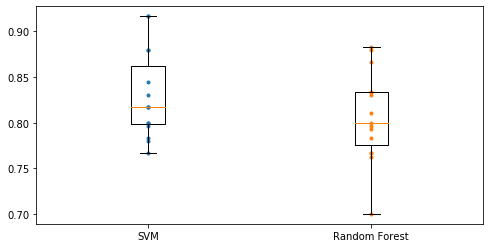

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot([1]*15, svm_score, ".")
plt.plot([2]*15, forest_score, ".")
plt.boxplot([svm_score, forest_score], labels=("SVM","Random Forest"))
plt.show()

In [154]:
forest_clf.feature_importances_

array([0.24906464, 0.02664155, 0.0243279 , 0.24135666, 0.05063215,
       0.02805367, 0.01539733, 0.05382561, 0.13485039, 0.14250254,
       0.01247275, 0.00776483, 0.01311   ])

In [167]:
feature_importance = pd.Series(forest_clf.feature_importances_, index=["Age", "SibSp", "Parch", "Fare", "Family Size", "Pclass_3", "Pclass_1", "Pclass_2", "Sex_male", "Sex_female", "Embarked_S", "Embarked_C", "Embarked_Q"])
feature_importance.sort_values(ascending=False)

Age            0.249065
Fare           0.241357
Sex_female     0.142503
Sex_male       0.134850
Pclass_2       0.053826
Family Size    0.050632
Pclass_3       0.028054
SibSp          0.026642
Parch          0.024328
Pclass_1       0.015397
Embarked_Q     0.013110
Embarked_S     0.012473
Embarked_C     0.007765
dtype: float64

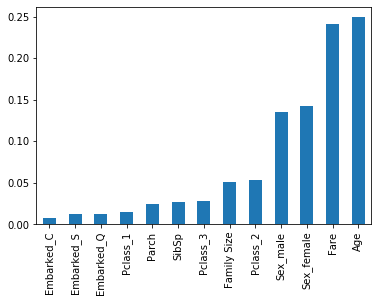

In [168]:
feature_importance.sort_values().plot(kind="bar")

In [180]:
svm_clf.dual_coef_

<1x408 sparse matrix of type '<class 'numpy.float64'>'
	with 408 stored elements in Compressed Sparse Row format>

In [190]:
train["RelativesOnboard"] = train["SibSp"] + train["Parch"]
train[["RelativesOnboard", "Survived"]].groupby(["RelativesOnboard"]).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [193]:
train[["Pclass", "Survived"]].groupby(["Pclass"]).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [194]:
train[["Sex", "Survived"]].groupby(["Sex"]).mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [198]:
train["FareBucket"] = train["Fare"] // 20 * 20
train[["FareBucket", "Survived"]].groupby(["FareBucket"]).mean()

,Survived
FareBucket,
0.0,0.277670
20.0,0.430000
40.0,0.574074
60.0,0.500000
80.0,0.869565
100.0,0.636364
120.0,0.909091
140.0,0.666667
160.0,1.000000
